<a href="https://colab.research.google.com/github/Egoluback/aijic2021_transport/blob/yarik/model4track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Any, Tuple, Union
import pickle
from tqdm import tqdm
from os.path import exists
from imblearn.over_sampling import SMOTE
from sktime.utils.data_processing import from_2d_array_to_nested

In [10]:
path = "./"

train_labeled = pd.read_csv(path + 'data/base_files/labled_train_data.csv', index_col=0, sep='\t', comment='#')
comments_labeled = pd.read_csv(path + 'data/base_files/labled_train_comments.csv', index_col=0, sep='\t', comment='#')
tracks_labeled = pd.read_csv(path + 'data/labled_train_tracks_speed.csv', index_col=0, sep=',', comment='#')

train_unlabeled = pd.read_csv(path +'data/base_files/unlabled_train_data.csv', index_col=0, sep='\t', comment='#')
comments_unlabeled = pd.read_csv(path+ 'data/base_files/unlabled_train_comments.csv', index_col=0, sep='\t', comment='#')
tracks_unlabeled = pd.read_csv(path+ 'data/unlabled_train_tracks_speed.csv', index_col=0, sep=',', comment='#')

Aggressive ride example

<AxesSubplot:>

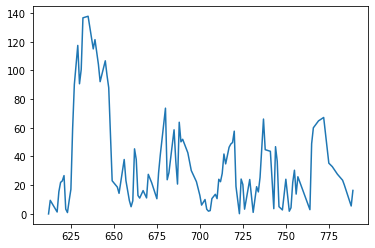

In [11]:
#tracks_labeled[tracks_labeled.ishttps://hostname:8080/?token=849d61a414abafab97bc4aab1f3547755ddc232c2b8cb7fe_aggressive==1]
from matplotlib import pyplot
series = tracks_labeled[tracks_labeled.order_id=='005781b9cfda88434a8dd976dc19da44'].speed
series.plot()

Non-aggressive ride example

<AxesSubplot:>

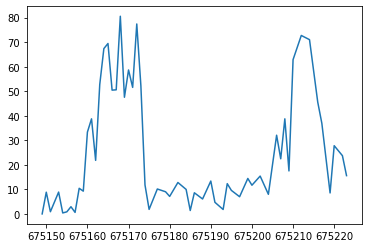

In [12]:
# 001662da857b5a39bb402aacf3145f86
series = tracks_labeled[tracks_labeled.order_id=='fffdfda358f35cf2d7f9d87d205655a7'].speed
series.plot()

In [13]:

tracks_labeled.drop_duplicates('order_id', keep='last').groupby(['is_aggressive']).count()

,Unnamed: 0.1,driver_id,dt,lat_,lon_,order_id,speed
is_aggressive,,,,,,,
0.0,8568,8568,8568,8568,8568,8568,8568
1.0,432,432,432,432,432,432,432


In [14]:
# mean time between two points
import datetime
mean = []
for order_id in tracks_labeled['order_id'].drop_duplicates()[:25]:
    mean.append(tracks_labeled[tracks_labeled.order_id==order_id].dt.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).diff().mean())
np.array(mean).mean()

Timedelta('0 days 00:00:35.470044128')

each order is different batch

In [45]:
class Preprocessing_labeled():
    def __init__(self, tracks_labeled,  chunk_size=10, multiplier=1):
        self.tracks = tracks_labeled
        self.MULTIPLIER = multiplier
        self.CHUNK_SIZE = chunk_size

    # undersampling method deletes some extra non aggressive values
    def undersampling(self, X):
        aggressive_count = sum(X.is_aggressive == 1)
        non_aggressive_ind = X[X.is_aggressive == 0].index

        # keep aggressive_count*multiplier number of non_aggressive samples
        random_indices = np.random.choice(
            non_aggressive_ind, aggressive_count*self.MULTIPLIER, replace=False)
        return pd.concat([X.loc[random_indices], X[X.is_aggressive == 1]])

    def split(self, arr):
        result = []
        # get right length of arr so that it equally splits into chunks
        length = len(arr)
        split_length = length - (length % self.CHUNK_SIZE)

        for i in range(split_length)[self.CHUNK_SIZE::self.CHUNK_SIZE]:
            result.append(arr[i-self.CHUNK_SIZE:i])

        return np.array(result)

    def preprocess_experimental(self, tracks):
        from tslearn.utils import to_time_series_dataset
        copied_tracks = tracks.copy()
        orders = copied_tracks.drop_duplicates('order_id', keep='last')
        # trying to use different method for balancing datasets, 
        # called class weights balancing. It automaticly proceeds in the classifier
        # trying blend two methods

        orders = self.undersampling(orders)

        y_labels = []
        X_train = []
        for order in tqdm(orders['order_id']):
            order_df = copied_tracks[copied_tracks.order_id == order]
            y_labels.append(order_df.is_aggressive.iloc[0])
            order_df: pd.DataFrame = order_df['speed'].to_numpy()
            order_df[0] = 0
            X_train.append(order_df.tolist())
        from tslearn.preprocessing import TimeSeriesScalerMinMax
        X_train = to_time_series_dataset(X_train)
        X_scaled = TimeSeriesScalerMinMax().fit_transform(X_train)
        return X_scaled, y_labels

    # make df, so that each row has Series object with order speeds
    def make_nested(self, tracks,):
        copied_tracks = tracks.copy()
        orders = copied_tracks.drop_duplicates('order_id', keep='last')
        # trying to use different method for balancing datasets, 
        # called class weights balancing. It automaticly proceeds in the classifier
        # trying blend two methods

        orders = self.undersampling(orders)

        y_labels = []
        X_train = []
        for order in tqdm(orders['order_id']):
            order_df = copied_tracks[copied_tracks.order_id == order]
            order_df.loc[0, 'speed'] = 0

            if order_df.shape[0] < self.CHUNK_SIZE:
                continue

            splitted_arrs = self.split(order_df.values)
            for arr in splitted_arrs:
                is_aggressive = arr[0][7]
                y_labels.append(is_aggressive)
                speed_series = []
                for row in arr:  
                    # append only speed 
                    speed_series.append(row[6])
                X_train.append(speed_series)

        return from_2d_array_to_nested(np.array(X_train)), np.array(y_labels)

In [26]:

class Preprocessing_unlabeled():
    def __init__(self, tracks_unlabeled, chunk_size=20, multiplier=1):
        self.CHUNK_SIZE = chunk_size
        self.MULTIPLIER = multiplier
        self.tracks = tracks_unlabeled

    def split(self, arr,):
        result = []
        # get right length of arr so that it equally splits into chunks
        length = len(arr)
        split_length = length - (length % self.CHUNK_SIZE)

        for i in range(split_length)[self.CHUNK_SIZE::self.CHUNK_SIZE]:
            result.append(arr[i-self.CHUNK_SIZE:i])

        return np.array(result)

    # undersampling method deletes extra non aggressive values
    def undersampling(self, X, y):
        aggressive_count = np.sum(y)
        non_aggressive_ind = np.argwhere(y == 0.0).flatten()
        aggressive_ind = np.argwhere(y == 1.0).flatten()

        if aggressive_count>len(non_aggressive_ind):
            print("number of aggressive samples is bigger than non aggressive ones")
            return X, y

        # keep aggressive_count*multiplier number of non_aggressive samples
        random_indices = np.random.choice(
            non_aggressive_ind, int(aggressive_count)*self.MULTIPLIER, replace=False)

        undersampling_X = np.concatenate(
            [np.take(X, random_indices, 0), 
             np.take(X, aggressive_ind, 0)])
        undersampling_y = np.concatenate(
            [np.take(y, aggressive_ind), 
             np.take(y, random_indices)])
        return undersampling_X, undersampling_y

    # make df, so that each row has Series object with order speeds
    def make_nested(self, tracks):
        orders = tracks.drop_duplicates('order_id', keep='last')
        X_train = []
        for order in tqdm(orders['order_id']):
            order_df = tracks[tracks.order_id == order]
            order_df.loc[0, 'speed'] = 0

            if order_df.shape[0] < self.CHUNK_SIZE:
                continue
            
            splitted_arrs = self.split(order_df.values)
            for arr in splitted_arrs:
                
                speed_series = []
                for row in arr:
                    # append only speed
                    speed_series.append(row[5])
                X_train.append(speed_series)
        
        return from_2d_array_to_nested(np.array(X_train))


In [61]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
import sklearn.linear_model
import json
from sklearn.svm import LinearSVC


class Model4track():
    def __init__(self, train_labeled, tracks_labeled, tracks_unlabeled, labeled_trained_model_path, semisupervised_model_path, get_score=True):
        self.rocket = MiniRocket()
        self.get_score = get_score
        self.train_labeled = train_labeled
        self.tracks_unlabeled = tracks_unlabeled
        self.tracks_labeled = tracks_labeled
        self.preprocessing_unlabeled = Preprocessing_unlabeled(
            self.tracks_unlabeled, 12, 1)
        self.preprocessing_labeled = Preprocessing_labeled(
            self.tracks_labeled, 12, 1)
        self.labled_trained_model_path = labeled_trained_model_path
        self.semisupervised_model_path = semisupervised_model_path
        self.unlabled_preprocessed_path = './data/pseudo_X.json'

    def train(self, X_train_transform, y_train, X_test_transform, y_test):

        if self.get_score:
            classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True, class_weight='balanced', cv=4, scoring='roc_auc')
            classifier = SGDClassifier(loss='log', class_weight='balanced')
            classifier = RidgeClassifier(normalize=True, class_weight='balanced') 
            classifier = RidgeClassifierCV(class_weight='balanced') # 0.61 !!!!!!!!!
            classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), class_weight='balanced') # 0.61 !!!!!!!!!
            classifier = SGDClassifier(loss='log', class_weight='balanced')
            classifier = LinearSVC(class_weight = 'balanced')
            #classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True, class_weight='balanced') # 0.53
            #classifier = SVC(gamma='auto', class_weight='balanced') # 0.48

        classifier.fit(X_train_transform, y_train)
        if self.get_score:
            #from sklearn.model_selection import cross_val_score
            #score = cross_val_score(classifier, X_train_transform, y_train, cv = 4, scoring = 'roc_auc')
            y_predicted = classifier.predict(X_test_transform)
            test_score = sklearn.metrics.roc_auc_score(y_test, y_predicted)
            print("________________SCORE____________________")
            print(test_score)
            return classifier

        return classifier
    
    def train_example(self,):
        def convert(x):
            if hasattr(x, "tolist"):  # numpy arrays have this
                return {"$array": x.tolist()}  # Make a tagged object
            raise TypeError(x)

        def deconvert(x):
            if len(x) == 1:  # Might be a tagged object...
                key, value = next(iter(x.items()))  # Grab the tag and value
                if key == "$array":  # If the tag is correct,
                    return np.array(value)  # cast back to array
            return x


        cached_data_path = 'data/labeled_preprocessed_exp.pkl'
        cached_y_data_path = 'data/labeled_y_preprocessed_exp.pkl'
        if exists(cached_data_path):

            with open(cached_data_path, 'rb') as X_file, open(cached_y_data_path) as y_file:
                X_train = pickle.load(X_file) 
                print(X_train)
                y_train = np.array(json.load(y_file, object_hook=deconvert))
        else:
            X_train, y_train = self.preprocessing_labeled.preprocess_experimental(
                self.tracks_labeled)
            print(X_train)
            with open(cached_data_path, 'wb') as X_file, open(cached_y_data_path, 'w') as y_file:
                pickle.dump(X_train ,X_file)
                json.dump(y_train, y_file, default=convert)

        from tslearn.neighbors import KNeighborsTimeSeriesClassifier
        from tslearn.svm import TimeSeriesSVC
        from tslearn.shapelets import LearningShapelets
        classifier = KNeighborsTimeSeriesClassifier(n_jobs=-1, verbose=2,n_neighbors=1)
        #classifier = TimeSeriesSVC(C=1.0, kernel="gak", class_weight=True, cache_size=10000, n_jobs=1, probability=True, max_iter=1, gamma='auto', verbose=2,)
        #classifier = LearningShapelets(max_iter = 10, verbose=1, batch_size=32, random_state=42,shapelet_length=0.15) 
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        print(X_train)
        #for train_index, test_index in kf.split(X_train):
        #    X_kfold, X_test = X_train[train_index], X_train[test_index]
        #    y_kfold, y_test= y_train[train_index], y_train[test_index]
        classifier.fit(X_train, y_train)
        file_path = './penis2.pkl'
        classifier.to_pickle(file_path)
        y_pred = classifier.predict(X_test)
        print(sum(y_pred))
        from sklearn.metrics import f1_score
        from sklearn.metrics import roc_auc_score
        test_score = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test,y_pred)
        print("________________SCORE____________________")
        print(test_score,roc_auc)

        #if self.get_score:
            #from sklearn.model_selection import cross_val_score
            #score = cross_val_score(classifier, X_train_transform, y_train, cv = 4, scoring = 'roc_auc')
        #    y_pred = classifier.predict(X_test)
        #    print(y_pred)
        #    print(y_test)
        #    from sklearn.metrics import f1_score
        #    from sklearn.metrics import roc_auc_score
        #    test_score = f1_score(y_test, y_pred)
        #    roc_auc = roc_auc_score(y_test,y_pred)
        #    print("________________SCORE____________________")
        #    print(test_score,roc_auc)
        #    return classifier

        return classifier
    


    def train_labeled_clf(self) -> sklearn.linear_model:
        def convert(x):
            if hasattr(x, "tolist"):  # numpy arrays have this
                return {"$array": x.tolist()}  # Make a tagged object
            raise TypeError(x)

        def deconvert(x):
            if len(x) == 1:  # Might be a tagged object...
                key, value = next(iter(x.items()))  # Grab the tag and value
                if key == "$array":  # If the tag is correct,
                    return np.array(value)  # cast back to array
            return x

        cached_data_path = 'data/labeled_preprocessed.json'
        cached_y_data_path = 'data/labeled_y_preprocessed.json'
        if exists(cached_data_path):

            # json was chosen, because i didn't find a way to read nested dataframe from csv file
            with open(cached_data_path) as X_file, open(cached_y_data_path) as y_file:
                X_train = np.array(json.load(X_file, object_hook=deconvert))
                y_train = np.array(json.load(y_file, object_hook=deconvert))
        else:
            X_train, y_train = self.preprocessing_labeled.preprocess_experimental(
                self.tracks_labeled)
            with open(cached_data_path, 'w') as X_file, open(cached_y_data_path, 'w') as y_file:
                json.dump(X_train.to_numpy(), X_file, default=convert)
                json.dump(y_train, y_file, default=convert)

        print("____TRAIN DATA_____")     
        print('numer of non aggressive samples')
        print(len(y_train))
        print('numer of aggressive samples')
        print(sum(y_train)/len(y_train)) 
        

        if self.get_score:
            X_train, X_test, y_train, y_test = train_test_split(
                X_train, y_train, test_size=0.3, random_state=44)
            y_test = np.array(y_test)

            self.rocket.fit(X_train)
            X_train_transform = self.rocket.transform(X_train)
            X_test_transform = self.rocket.transform(X_test)

            print("___TEST_DATA___")
            print('numer of non aggressive samples')
            print(len(y_test)-sum(y_test))
            print('numer of aggressive samples')
            print(sum(y_test))
        else:
            self.rocket.fit(X_train)
            X_train_transform = self.rocket.transform(X_train)

        clf = self.train(X_train_transform, y_train, X_test_transform, y_test) 
        return clf

    def ss_train(self) -> sklearn.linear_model:
        '''
        Semi-supervised training algorithm. We train classifier on our labeled data, 
        then use this classifier to label unlabeled data 
        and retrain classifier on this pseudo-labeled data 
        '''

        # check if pretrained model exist
        if not exists(self.labled_trained_model_path):
            classifier= self.train_labeled_clf()
            with open(self.labled_trained_model_path, mode='wb') as file:
                pickle.dump(classifier, file)
        else:
            with open(self.labled_trained_model_path, mode='rb') as file:
                classifier = pickle.load(file)


        # unsupervised learning
        if exists(self.unlabled_preprocessed_path):
            with open(self.unlabled_preprocessed_path) as file:
                pseudo_X = np.asarray(json.load(file, object_hook=deconvert))
                pseudo_X = np.array([x[0] for x in pseudo_X])
                pseudo_X = from_2d_array_to_nested(pseudo_X)
        else:
            pseudo_X = self.preprocessing_unlabeled.make_nested(
                self.tracks_unlabeled)
            with open(self.unlabled_preprocessed_path, 'w') as file:
                json.dump(pseudo_X.to_numpy(), file, default=convert)

        self.rocket.fit(pseudo_X)
        transformed_pseudo_X = self.rocket.transform(pseudo_X)
        pseudo_y = classifier.predict(transformed_pseudo_X)

        # if number of aggressive samples less than non agressive
        #if sum(pseudo_y) < len(pseudo_y)/2:
        #    pseudo_X, pseudo_y = self.preprocessing_unlabeled.undersampling(
        #        pseudo_X, pseudo_y)

        all_X_transform = pd.concat([transformed_pseudo_X, X_train_transform])
        all_y = np.concatenate((pseudo_y, y_train))

        #semisupervised_classifer = self.train(
        #    all_X_transform, all_y, None, None)
        #semisupervised_classifier = classifier
        #with open(self.semisupervised_model_path, 'wb+') as file:
        #    pickle.dump(semisupervised_classifier, file)
        return classifier


Self-training realization:
1. Make pseudo-labels for unlabled data
2. Retrain classifier on labled and pseudolabled data
https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38 

In [62]:

labeled_trained_model_path = './models/labeled_trained_classifier.pkl'
semisupervised_model_path = './models/emisupervised_classifier.pkl'
model = Model4track(train_labeled, tracks_labeled, tracks_unlabeled, labeled_trained_model_path, semisupervised_model_path)
model.train_example()

[[[0.        ]
  [0.07408544]
  [0.14884833]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.02285857]
  [0.40191864]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.00412213]
  [0.01906335]
  ...
  [       nan]
  [       nan]
  [       nan]]

 ...

 [[0.        ]
  [0.04398757]
  [0.16208463]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.00408514]
  [0.09618655]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.12048261]
  [0.12842466]
  ...
  [       nan]
  [       nan]
  [       nan]]]
[[[0.        ]
  [0.01379422]
  [0.00648985]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.01840576]
  [0.09856856]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.        ]
  [0.06521994]
  [0.08110174]
  ...
  [       nan]
  [       nan]
  [       nan]]

 ...

 [[0.        ]
  [0.04136817]
  [0.20684085]
  ...
  [       nan]
  [       nan]
  [       nan]]

 [[0.   

KeyboardInterrupt: 

In [35]:
classifier = None
def penis():
    #X_train, y_train = preprocessing_labeled.make_nested(tracks_labeled)

    cached_data_path = 'data/labeled_preprocessed.json'
    cached_y_data_path = 'data/labeled_y_preprocessed.json'
    def deconvert(x):
        if len(x) == 1:  # Might be a tagged object...
            key, value = next(iter(x.items()))  # Grab the tag and value
            if key == "$array":  # If the tag is correct,
                return np.array(value)  # cast back to array
        return x

    with open(cached_data_path) as X_file, open(cached_y_data_path) as y_file:
                    X_train = json.load(X_file, object_hook=deconvert)
                    X_train = np.array([x[0] for x in X_train]) 
                    y_train = np.array(json.load(y_file, object_hook=deconvert))
    X_test =pd.read_csv('./data/test_tracks_speed.csv', sep=',')
    preprocessing= Preprocessing_unlabeled(X_test, chunk_size=40)
    X_test = preprocessing.make_nested(X_test)
    X_train = from_2d_array_to_nested(np.array(X_train))

    rocket = MiniRocket()
    rocket.fit(X_test)
    X_test_transform = rocket.transform(X_test)
    with open('./models/labeled_trained_classifier069.pkl', 'rb') as file:
        classifier = pickle.load(file)

    return classifier.predict(X_test_transform)

In [37]:
predicted = penis()
pd.DataFrame(predicted, columns=['is_aggressive'])

  0%|          | 0/1272 [00:00<?, ?it/s]/opt/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-9-d6cbc6aacfb2>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_df.loc[0, 'speed'] = 0
100%|██████████| 1272/1272 [00:07<00:00, 172.19it/s]


,is_aggressive
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
456,1.0
457,1.0
458,0.0
459,0.0


In [ ]:
b = np.array(scores)
print(b.mean())
c = np.array(percent)
np.corrcoef(b,c) 

In [ ]:
def deconvert(x):
    if len(x) == 1:  # Might be a tagged object...
        key, value = next(iter(x.items()))  # Grab the tag and value
        if key == "$array":  # If the tag is correct,
            return np.array(value)  # cast back to array
    return x

with open('./data/labeled_y_preprocessed.json', 'r') as file:
    data = json.load(file, object_hook=deconvert)

print(data)
aggressive = sum(data)
non_aggressive = len(data) - aggressive
print(aggressive)
print(non_aggressive)
print(aggressive/non_aggressive*100)

In [ ]:
with open(cached_data_path) as X_file, open(cached_y_data_path) as y_file:
    X_train = json.load(X_file, object_hook=deconvert)
    X_train = np.array([x[0] for x in X_train])
    X_train = from_2d_array_to_nested(X_train)
    y_train = np.array(json.load(y_file, object_hook=deconvert))

with open('./penis.pkl', 'rb') as file:
    classifier = pickle.load(file) 

TRAIN DATA ANALYSIS

In [ ]:
from sktime.utils.data_processing import from_2d_array_to_nested
cached_data_path = 'data/labeled_preprocessed.json'
cached_y_data_path = 'data/labeled_y_preprocessed.json'
def deconvert(x):
    if len(x) == 1:  # Might be a tagged object...
        key, value = next(iter(x.items()))  # Grab the tag and value
        if key == "$array":  # If the tag is correct,
            return np.array(value)  # cast back to array
    return x

with open(cached_data_path) as X_file, open(cached_y_data_path) as y_file:
                X_train = np.array(json.load(X_file, object_hook=deconvert))
                a = from_2d_array_to_nested(X_train)
                y_train = json.load(y_file, object_hook=deconvert)
print(sum(y_train))
print((len(y_train)-sum(y_train))/sum(y_train))
